## Housing Data Analysis: King County, Washington


#### Authors: Justin Weible, Naomi Weinberger

### Business Problem

In order to help prospective home buyers in the Seattle area, we wanted to be able to predict the price of a house based on various characteristics, including proximity to the downtown Seattle area, year built, number of bedrooms, number of bathrooms, square footage, and the grade it was given by the King County Assessor's Office.

Multiple linear regression techniques were used in order to create a working model that could accurately predict the cost of a house given those specific characteristics.


### Dataset Understanding

The dataset that was used came from King County, Washington, and used housing data of houses from 2014.

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [6]:
df= pd.read_csv('data/kc_house_data.csv')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

### Data Cleaning

Before creating our linear regression model, we wanted to remove columns that we didn't think were going to be relevant when analyzing the cost of a house. We eliminated all columns except 'price','sqft_living','bedrooms','bathrooms','floors','grade','condition','yr_built','yr_renovated',and 'waterfront'. 

A new column labeled 'distance" was created, which used a geopy function to use the columns 'lat' and 'long' in order to determine the location of a house based on its distance from downtown. The resulting distance was then converted into miles.

We coverted 'yr_renovated' into a column labeled 'renovated' that would show whether a house had been renovated in its history. The column was converted into 0 for "not renovated" and 1 for "renovated", and all null values were changed to zeroes because we assumed that if a house didn't have a value in that column, it was likely not a renovated house.

We treated the null values in the column 'waterfront' in much the same way. If an entry didn't have a value in waterfront, it was assumed that it was not a waterfront property.

We also created a column called 'age' that took yr_built and subtracted it from 2014 in order to determine the exact age of the house.

A correlation matrix was also used to make sure that our columns were all related to one another in some way.

In [8]:
from geopy import distance

lat_long = df['lat'].astype(str) + ',' + df['long'].astype(str)
lat_long = list(map(eval, lat_long)) 

Seattle = (47.6062, -122.3321)
miles = []
for i in lat_long:
    miles.append(round(distance.distance(i, Seattle).miles, 1))
df['distance'] = miles

In [9]:
df=df[['price','sqft_living','bedrooms','bathrooms','floors','grade','condition','yr_built','yr_renovated','waterfront', 'distance']]
df

,price,sqft_living,bedrooms,bathrooms,floors,grade,condition,yr_built,yr_renovated,waterfront,distance
0,221900.0,1180,3,1.00,1.0,7,3,1955,0.0,NaN,7.4
1,538000.0,2570,3,2.25,2.0,7,3,1951,1991.0,0.0,8.0
2,180000.0,770,2,1.00,1.0,6,3,1933,NaN,0.0,10.2
3,604000.0,1960,4,3.00,1.0,7,5,1965,0.0,0.0,6.6
4,510000.0,1680,3,2.00,1.0,8,3,1987,0.0,0.0,13.4
...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,1530,3,2.50,3.0,8,3,2009,0.0,0.0,6.5
21593,400000.0,2310,4,2.50,2.0,8,3,2014,0.0,0.0,6.7
21594,402101.0,1020,2,0.75,2.0,7,3,2009,0.0,0.0,1.7
21595,400000.0,1600,3,2.50,2.0,8,3,2004,0.0,NaN,13.3


In [10]:
df.isnull().sum()

price              0
sqft_living        0
bedrooms           0
bathrooms          0
floors             0
grade              0
condition          0
yr_built           0
yr_renovated    3842
waterfront      2376
distance           0
dtype: int64

In [11]:
df['waterfront'] = df['waterfront'].fillna(0)

In [12]:
df.isnull().sum()
df['yr_renovated'] = df['yr_renovated'].fillna(0)
df.isnull().sum()

price           0
sqft_living     0
bedrooms        0
bathrooms       0
floors          0
grade           0
condition       0
yr_built        0
yr_renovated    0
waterfront      0
distance        0
dtype: int64

In [13]:
df.rename(columns={'yr_renovated': 'renovated'}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        21597 non-null  float64
 1   sqft_living  21597 non-null  int64  
 2   bedrooms     21597 non-null  int64  
 3   bathrooms    21597 non-null  float64
 4   floors       21597 non-null  float64
 5   grade        21597 non-null  int64  
 6   condition    21597 non-null  int64  
 7   yr_built     21597 non-null  int64  
 8   renovated    21597 non-null  float64
 9   waterfront   21597 non-null  float64
 10  distance     21597 non-null  float64
dtypes: float64(6), int64(5)
memory usage: 1.8 MB


In [14]:
df['age'] = 2015 - df.yr_built
df = df.drop(columns=['yr_built'], axis=1)

In [15]:
df.head()

,price,sqft_living,bedrooms,bathrooms,floors,grade,condition,renovated,waterfront,distance,age
0,221900.0,1180,3,1.00,1.0,7,3,0.0,0.0,7.4,60
1,538000.0,2570,3,2.25,2.0,7,3,1991.0,0.0,8.0,64
2,180000.0,770,2,1.00,1.0,6,3,0.0,0.0,10.2,82
3,604000.0,1960,4,3.00,1.0,7,5,0.0,0.0,6.6,50
4,510000.0,1680,3,2.00,1.0,8,3,0.0,0.0,13.4,28


In [16]:
renovated = df.renovated.values
age = df.age.values
values = np.where(renovated <= 10, 1, 0)
df['renovated'] = np.where(age <= 5, 1, values)

In [17]:
value_counts_bed=df['bedrooms'].value_counts()
to_remove = value_counts_bed[value_counts_bed <=50].index
df = df[~df.bedrooms.isin(to_remove)]

In [18]:
value_counts_bath=df['bathrooms'].value_counts()
to_remove_bath = value_counts_bath[value_counts_bath <=80].index
df = df[~df.bathrooms.isin(to_remove_bath)]

In [19]:
value_counts_floors=df['floors'].value_counts()
to_remove_floor = value_counts_floors[value_counts_floors <=10].index
df = df[~df.floors.isin(to_remove_floor)]

In [20]:
df.head()

,price,sqft_living,bedrooms,bathrooms,floors,grade,condition,renovated,waterfront,distance,age
0,221900.0,1180,3,1.00,1.0,7,3,1,0.0,7.4,60
1,538000.0,2570,3,2.25,2.0,7,3,0,0.0,8.0,64
2,180000.0,770,2,1.00,1.0,6,3,1,0.0,10.2,82
3,604000.0,1960,4,3.00,1.0,7,5,1,0.0,6.6,50
4,510000.0,1680,3,2.00,1.0,8,3,1,0.0,13.4,28


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21291 entries, 0 to 21595
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        21291 non-null  float64
 1   sqft_living  21291 non-null  int64  
 2   bedrooms     21291 non-null  int64  
 3   bathrooms    21291 non-null  float64
 4   floors       21291 non-null  float64
 5   grade        21291 non-null  int64  
 6   condition    21291 non-null  int64  
 7   renovated    21291 non-null  int32  
 8   waterfront   21291 non-null  float64
 9   distance     21291 non-null  float64
 10  age          21291 non-null  int64  
dtypes: float64(5), int32(1), int64(5)
memory usage: 1.9 MB


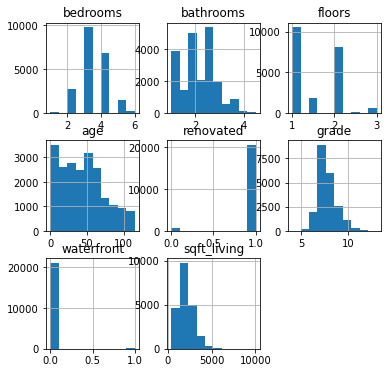

In [22]:
df[['bedrooms', 'bathrooms', 'floors', 'age','renovated','grade','waterfront','sqft_living']].hist(figsize  = [6, 6]); 

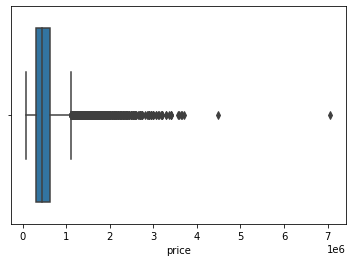

In [23]:
ax = sns.boxplot(x="price", data=df)

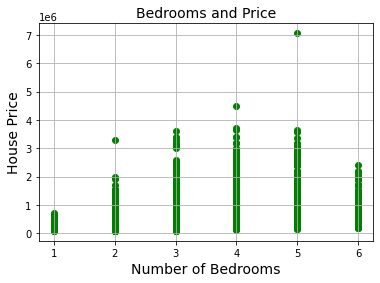

In [24]:
plt.scatter(df['bedrooms'], df['price'], color='green')
plt.title('Bedrooms and Price', fontsize=14)
plt.xlabel('Number of Bedrooms', fontsize=14)
plt.ylabel('House Price', fontsize=14)
plt.grid(True)
plt.show()

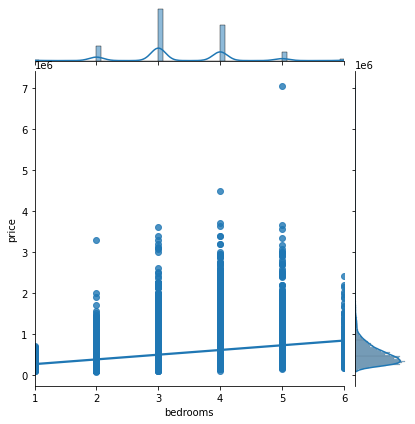

In [25]:
sns.jointplot(data=df, x="bedrooms", y="price", kind="reg")

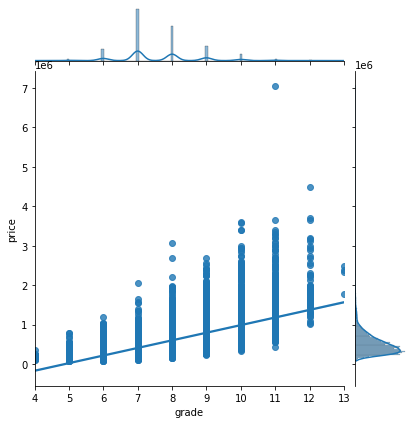

In [26]:
sns.jointplot(data=df, x="grade", y="price", kind="reg")

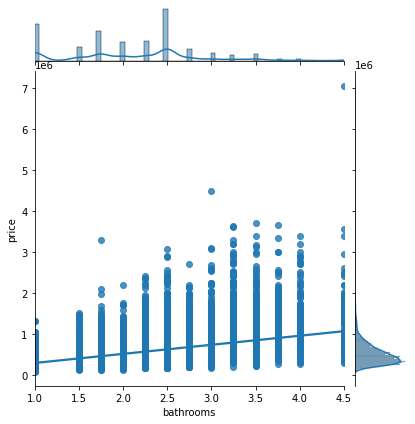

In [27]:
sns.jointplot(data=df, x="bathrooms", y="price", kind="reg")

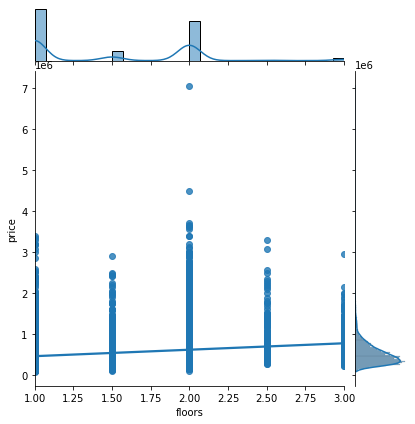

In [28]:
sns.jointplot(data=df, x="floors", y="price", kind="reg")

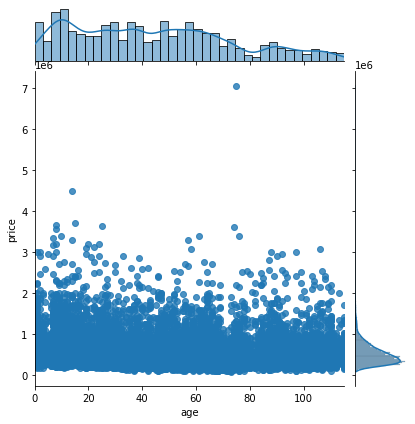

In [29]:
sns.jointplot(data=df, x="age", y="price", kind="reg")

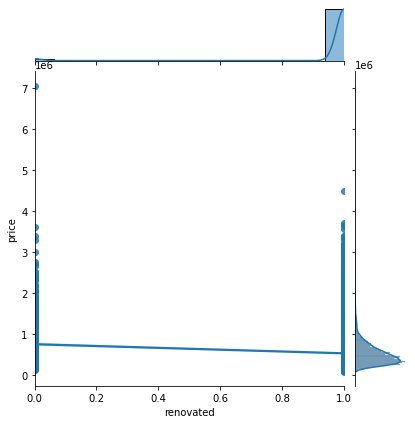

In [30]:
sns.jointplot(data=df, x="renovated", y="price", kind="reg")

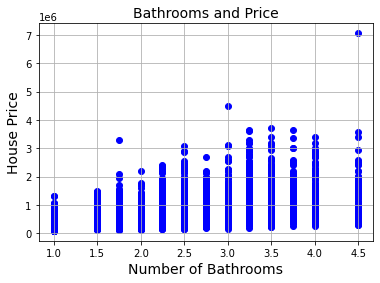

In [31]:
plt.scatter(df['bathrooms'], df['price'], color='blue')
plt.title('Bathrooms and Price', fontsize=14)
plt.xlabel('Number of Bathrooms', fontsize=14)
plt.ylabel('House Price', fontsize=14)
plt.grid(True)
plt.show()

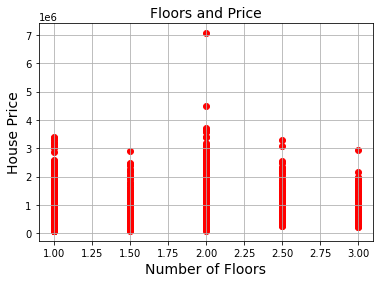

In [32]:
plt.scatter(df['floors'], df['price'], color='red')
plt.title('Floors and Price', fontsize=14)
plt.xlabel('Number of Floors', fontsize=14)
plt.ylabel('House Price', fontsize=14)
plt.grid(True)
plt.show()

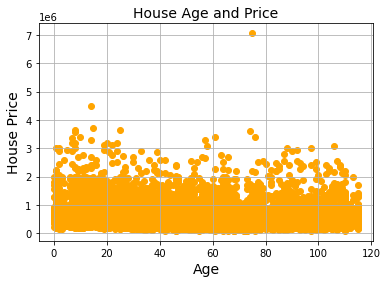

In [33]:
plt.scatter(df['age'], df['price'], color='orange')
plt.title('House Age and Price', fontsize=14)
plt.xlabel('Age', fontsize=14)
plt.ylabel('House Price', fontsize=14)
plt.grid(True)
plt.show()

<AxesSubplot:>

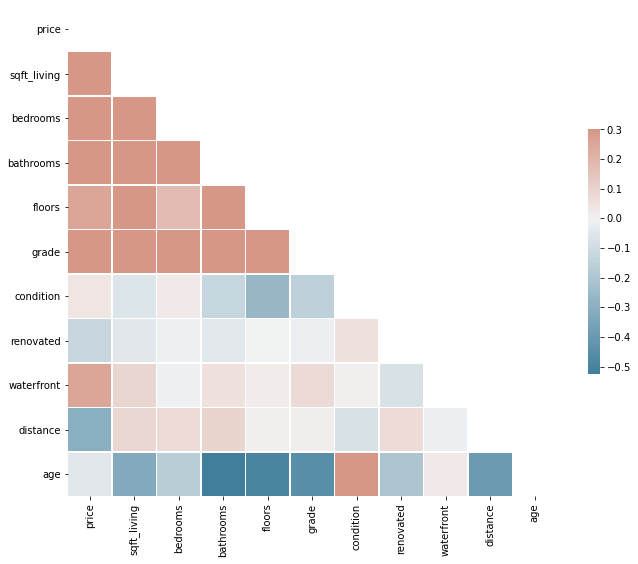

In [34]:
corr=df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Model 1

For our first model, we simply took the dataset and its columns and created the initial model based on the price of a house just to give us a starting point.

The first model had an R-squared value of 0.692 with a Test RMSE of 185212.7798740588 and a Train RMSE of 183591.80606517757.

Based on the QQ-plot and the distribution of the column 'price', we determined that there were significant outliers just in price that would need to be accounted for in our second model.

In [35]:
def tts_model(df):
    y = df['price']
    X = df.drop(columns=['price'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=123)
    
    linreg = LinearRegression()
    model = linreg.fit(X_train, y_train)

    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    mse_train = mean_squared_error(y_train, train_predictions)
    mse_test = mean_squared_error(y_test, test_predictions)
    
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    print('Test RMSE:', np.sqrt(mse_test))
    print('Train RMSE:', np.sqrt(mse_train))
    print('Training Score:', round(train_score, 2))
    print('Test Score:', round(test_score, 2))
    print('Coefficients:', model.coef_)

    X_train = sm.add_constant(X_train)
    smmodel = sm.OLS(y_train, X_train).fit()
    print(smmodel.summary())
    return smmodel

In [36]:
model = tts_model(df)

Test RMSE: 185212.7798740588
Train RMSE: 183591.80606517757
Training Score: 0.69
Test Score: 0.68
Coefficients: [ 1.80491024e+02 -3.43265701e+04  1.92287809e+04 -5.58838958e+03
  1.10775024e+05  3.11113403e+04 -6.68291343e+04  7.19920196e+05
 -1.40294460e+04  1.55210948e+03]
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     3831.
Date:                Mon, 26 Jul 2021   Prob (F-statistic):               0.00
Time:                        11:49:13   Log-Likelihood:            -2.3060e+05
No. Observations:               17032   AIC:                         4.612e+05
Df Residuals:                   17021   BIC:                         4.613e+05
Df Model:                          10                                         
Covariance Ty

<Figure size 864x576 with 0 Axes>

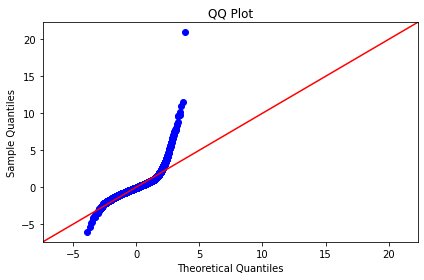

In [37]:
plt.figure(figsize=(12, 8))
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
plt.title('QQ Plot')
plt.tight_layout()

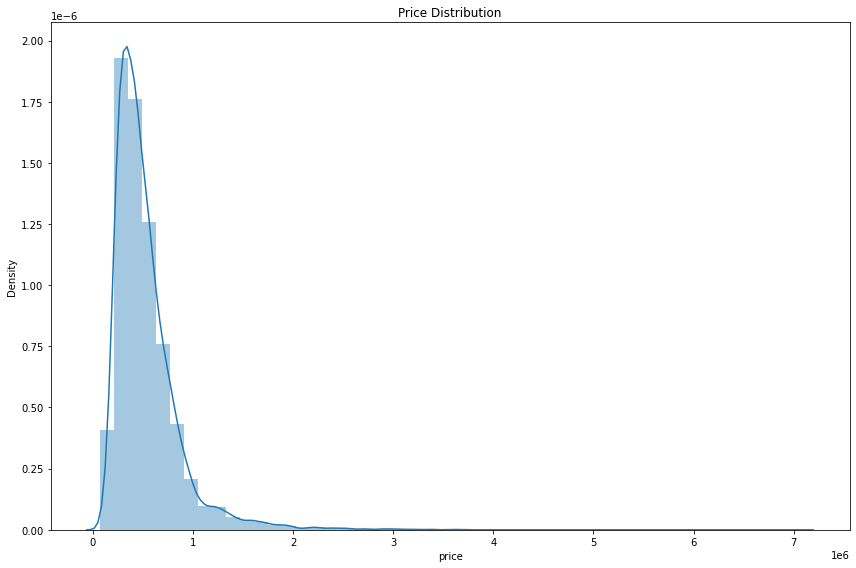

In [38]:
plt.figure(figsize=(12, 8))
sns.distplot(df.price)
plt.title('Price Distribution')
plt.tight_layout()

## Model 2 (Normalizing Price)

Our second model was created just to remove outliers in price. A figure of $1,000,000 was chosen as the maximum price of a house to limit the prediction model to what we consider to be an affordable cost. It also gave the data in price a much more normalized distribution.

The R-squared value dropped to 0.636, but we saw a significant improvement in our Test RMSE (Root Mean Square Error) and our Train RMSE.

In [39]:
df = df[df['price'] <= 1000001]

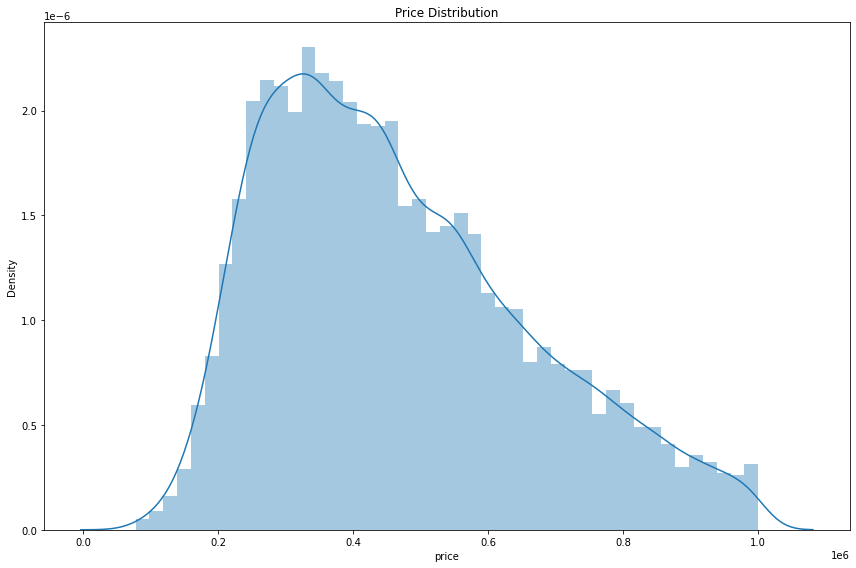

In [40]:
plt.figure(figsize=(12, 8))
sns.distplot(df.price)
plt.title('Price Distribution')
plt.tight_layout()

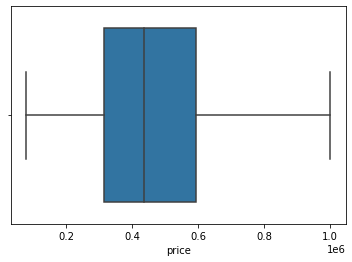

In [41]:
ax = sns.boxplot(x="price", data=df)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19967 entries, 0 to 21595
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        19967 non-null  float64
 1   sqft_living  19967 non-null  int64  
 2   bedrooms     19967 non-null  int64  
 3   bathrooms    19967 non-null  float64
 4   floors       19967 non-null  float64
 5   grade        19967 non-null  int64  
 6   condition    19967 non-null  int64  
 7   renovated    19967 non-null  int32  
 8   waterfront   19967 non-null  float64
 9   distance     19967 non-null  float64
 10  age          19967 non-null  int64  
dtypes: float64(5), int32(1), int64(5)
memory usage: 1.8 MB


In [43]:
model = tts_model(df)

Test RMSE: 116300.25070882679
Train RMSE: 118230.5826784761
Training Score: 0.64
Test Score: 0.65
Coefficients: [ 1.14194351e+02 -1.48798380e+04  1.30532362e+04  1.03094704e+04
  8.25511055e+04  2.34649817e+04 -2.86649532e+04  2.02536792e+05
 -1.05013836e+04  1.08555823e+03]
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                     2789.
Date:                Mon, 26 Jul 2021   Prob (F-statistic):               0.00
Time:                        11:49:14   Log-Likelihood:            -2.0924e+05
No. Observations:               15973   AIC:                         4.185e+05
Df Residuals:                   15962   BIC:                         4.186e+05
Df Model:                          10                                         
Covariance Ty

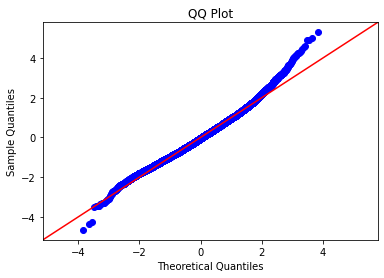

In [44]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
plt.title('QQ Plot')
plt.show()

## Model 3 (Multicollinearity)

Our third model took multicollinearity into account. Looking at correlation pairs, the only strong correlation between two independent variables was between sqft_living and bathrooms. But because none of the variance inflation factors were higher than 3.3, multicollinearity didn't appear to be a real issue in this model.

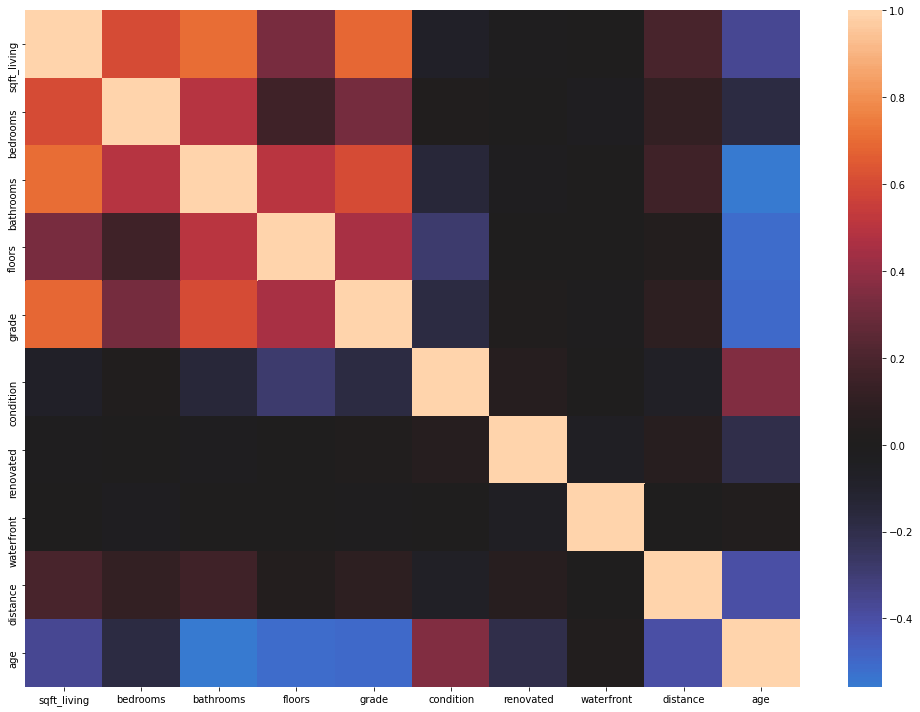

In [45]:
X = df.drop(columns=['price'], axis=1)
plt.figure(figsize=(14, 10))
sns.heatmap(X.corr(), center=0)
plt.tight_layout()
plt.show()

In [46]:
abs(X.corr()) >= .7

,sqft_living,bedrooms,bathrooms,floors,grade,condition,renovated,waterfront,distance,age
sqft_living,True,False,True,False,False,False,False,False,False,False
bedrooms,False,True,False,False,False,False,False,False,False,False
bathrooms,True,False,True,False,False,False,False,False,False,False
floors,False,False,False,True,False,False,False,False,False,False
grade,False,False,False,False,True,False,False,False,False,False
condition,False,False,False,False,False,True,False,False,False,False
renovated,False,False,False,False,False,False,True,False,False,False
waterfront,False,False,False,False,False,False,False,True,False,False
distance,False,False,False,False,False,False,False,False,True,False
age,False,False,False,False,False,False,False,False,False,True


In [47]:
corr_df = X.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# Zip the variable name columns in a  column named "pairs"
corr_df['pairs'] = list(zip(corr_df.level_0, corr_df.level_1))

# Set index to pairs
corr_df.set_index(['pairs'], inplace = True)

# Drop level columns
corr_df.drop(columns=['level_1', 'level_0'], inplace = True)

# Rename correlation column to cc
corr_df.columns = ['cc']

# Drop duplicates
corr_df.drop_duplicates(inplace=True)

In [48]:
corr_df[(corr_df.cc>.70) & (corr_df.cc <1)]

,cc
pairs,
"(sqft_living, bathrooms)",0.703893


In [49]:
X = sm.add_constant(X)
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_dict = dict(zip(X.columns, vif))
vif_dict

{'const': 227.37496098764228,
 'sqft_living': 3.394643548759592,
 'bedrooms': 1.6706372476090992,
 'bathrooms': 2.868144204903143,
 'floors': 1.639885479908926,
 'grade': 2.4537733240600215,
 'condition': 1.2072300584062268,
 'renovated': 1.0994499286122628,
 'waterfront': 1.0051787242619208,
 'distance': 1.3301798446525763,
 'age': 2.548581218899425}

In [50]:
tts_model(df)

Test RMSE: 116300.25070882679
Train RMSE: 118230.5826784761
Training Score: 0.64
Test Score: 0.65
Coefficients: [ 1.14194351e+02 -1.48798380e+04  1.30532362e+04  1.03094704e+04
  8.25511055e+04  2.34649817e+04 -2.86649532e+04  2.02536792e+05
 -1.05013836e+04  1.08555823e+03]
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                     2789.
Date:                Mon, 26 Jul 2021   Prob (F-statistic):               0.00
Time:                        11:49:15   Log-Likelihood:            -2.0924e+05
No. Observations:               15973   AIC:                         4.185e+05
Df Residuals:                   15962   BIC:                         4.186e+05
Df Model:                          10                                         
Covariance Ty

## Model 4 (Removing Insignificant Features)

Based on the p-values in our model, no feature was considered statistically insignificant. However, we decided to drop 'renovated' from our model just to see if it improved the accuracy of our model.

Removing 'renovated' did improve the Test RMSE and the Train RMSE slightly, although the R-squared value did decrease.

In [51]:
df = df.drop(columns=['renovated'], axis=1)

In [52]:
tts_model(df)

Test RMSE: 116269.1099711106
Train RMSE: 118323.48748544577
Training Score: 0.64
Test Score: 0.65
Coefficients: [ 1.14070516e+02 -1.51465282e+04  1.46418685e+04  1.09565579e+04
  8.27169236e+04  2.23230332e+04  2.07430535e+05 -1.04481692e+04
  1.16167759e+03]
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     3092.
Date:                Mon, 26 Jul 2021   Prob (F-statistic):               0.00
Time:                        11:49:15   Log-Likelihood:            -2.0925e+05
No. Observations:               15973   AIC:                         4.185e+05
Df Residuals:                   15963   BIC:                         4.186e+05
Df Model:                           9                                         
Covariance Type:            n

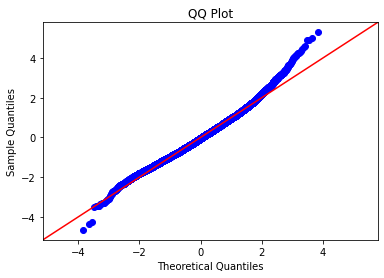

In [53]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
plt.title('QQ Plot')
plt.show()

## Model 5: Adjusting for Outliers

For Model 5, we wanted to look at outliers in the multiple independent variables to see if that was affecting our model in some way.

Through looking at multiple graphs, the biggest outliers were in 'sqft_living', 'bathrooms', and 'floors'.

Based on those graphs, we decided to limit our model to evaluating houses that were less that 5,000 square feet, had fewer that 4 bathrooms, and had 3 floors or less.

Refining the model in this way, our RMSE actually increased and our R-squared increased to 0.636. 

However, the difference between our Train RMSE and Test RMSE narrowed from previous models, and a higher Test RMSE suggests that the data in our model might be slightly overfitted.

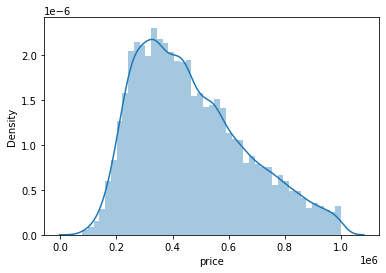

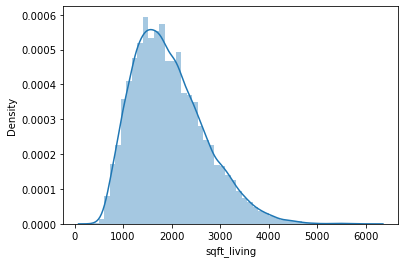

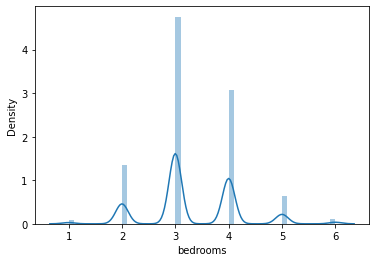

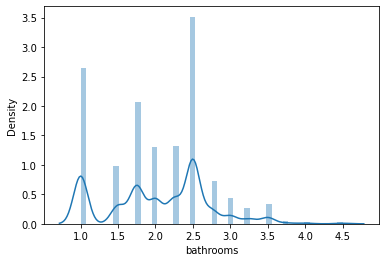

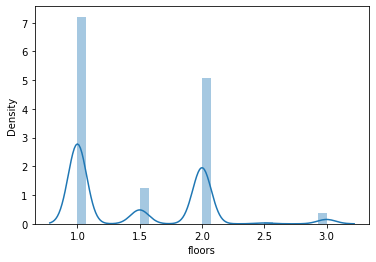

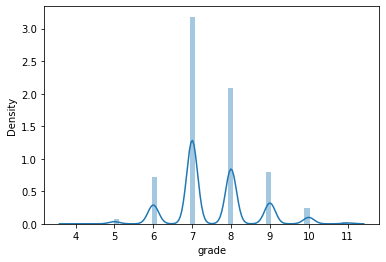

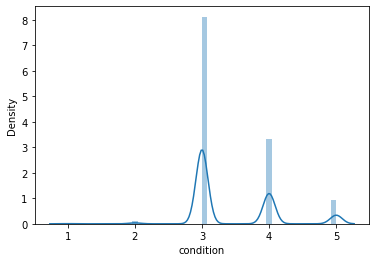

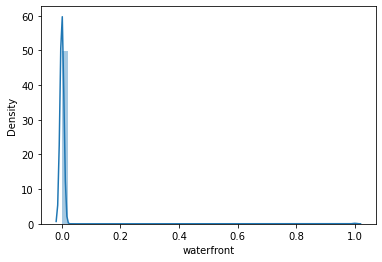

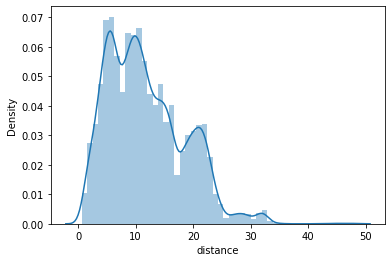

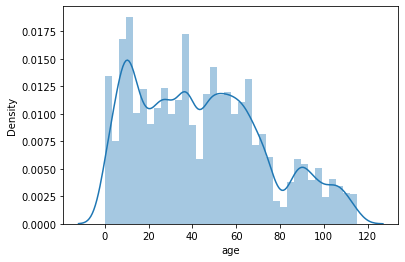

In [54]:
#View distribution plots for all columns
for col in df.columns:
    plt.subplots(1, 1)
    sns.distplot(df[col])

In [55]:
df = df[df['sqft_living'] < 5000]
df = df[df['bathrooms'] < 4.0]
df = df[df['floors'] < 3.5]

In [56]:
tts_model(df)

Test RMSE: 118699.94682993456
Train RMSE: 117268.67577402371
Training Score: 0.64
Test Score: 0.63
Coefficients: [ 1.15845494e+02 -1.55779243e+04  1.56622948e+04  1.37796855e+04
  8.13836011e+04  2.28256498e+04  1.96048576e+05 -1.04005570e+04
  1.17294712e+03]
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     3094.
Date:                Mon, 26 Jul 2021   Prob (F-statistic):               0.00
Time:                        11:49:17   Log-Likelihood:            -2.0798e+05
No. Observations:               15887   AIC:                         4.160e+05
Df Residuals:                   15877   BIC:                         4.161e+05
Df Model:                           9                                         
Covariance Type:            

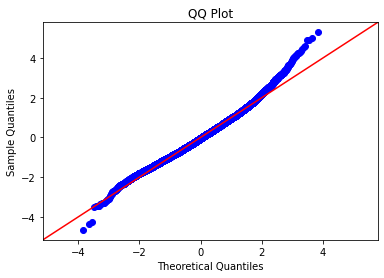

In [57]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
plt.title('QQ Plot')
plt.show()

## Homoscedascity

Model 5 became our final model, so we did a quick check for homoscedascity. With the exception of a few outliers, our residuals are relatively homoscedastic.

In [58]:
y = df['price']
X = df.drop(columns=['price'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=123)
    
linreg = LinearRegression()
model = linreg.fit(X_train, y_train)

train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

mse_train = mean_squared_error(y_train, train_predictions)
mse_test = mean_squared_error(y_test, test_predictions)
    
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print('Test RMSE:', np.sqrt(mse_test))
print('Train RMSE:', np.sqrt(mse_train))
print('Training Score:', round(train_score, 2))
print('Test Score:', round(test_score, 2))
print('Coefficients:', model.coef_)

X_train = sm.add_constant(X_train)
smmodel = sm.OLS(y_train, X_train).fit()
print(smmodel.summary())

Test RMSE: 118699.94682993456
Train RMSE: 117268.67577402371
Training Score: 0.64
Test Score: 0.63
Coefficients: [ 1.15845494e+02 -1.55779243e+04  1.56622948e+04  1.37796855e+04
  8.13836011e+04  2.28256498e+04  1.96048576e+05 -1.04005570e+04
  1.17294712e+03]
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     3094.
Date:                Mon, 26 Jul 2021   Prob (F-statistic):               0.00
Time:                        11:49:18   Log-Likelihood:            -2.0798e+05
No. Observations:               15887   AIC:                         4.160e+05
Df Residuals:                   15877   BIC:                         4.161e+05
Df Model:                           9                                         
Covariance Type:            

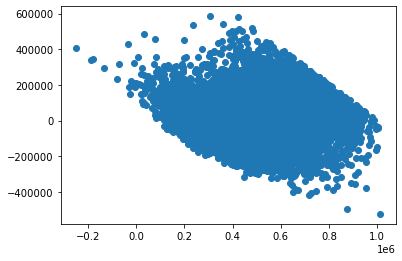

In [59]:
plt.scatter(train_predictions, smmodel.resid)

## Plots

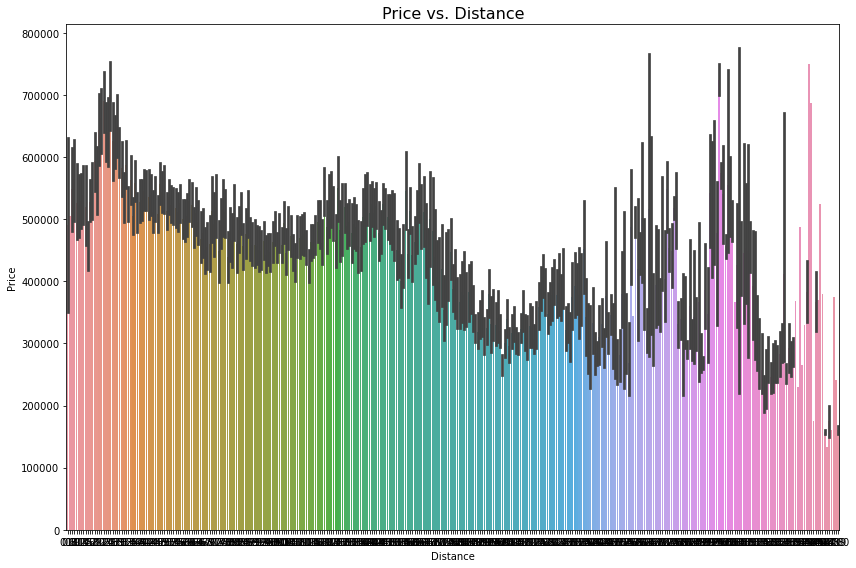

In [60]:
plt.figure(figsize=(12, 8))
sns.barplot(df['distance'], df['price'])
plt.title('Price vs. Distance', fontsize=16)
plt.xlabel('Distance')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

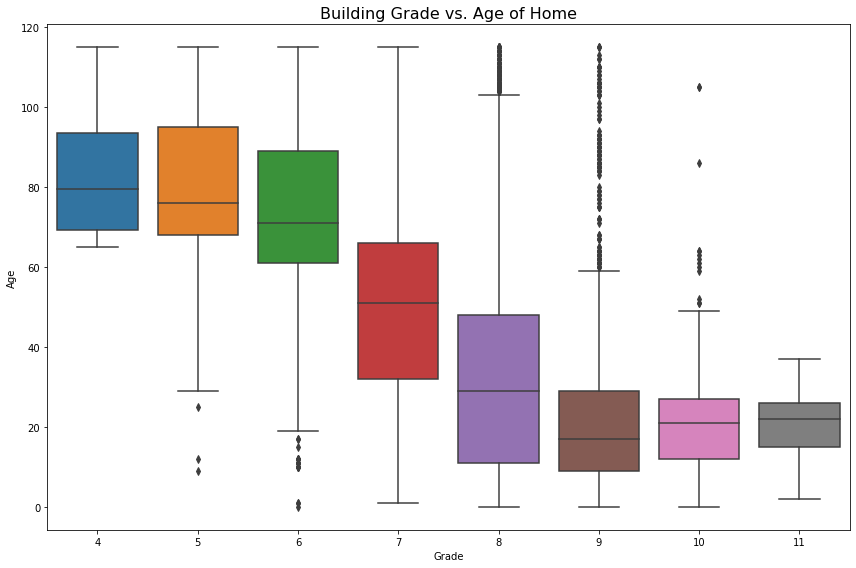

In [61]:
plt.figure(figsize=(12, 8))
sns.boxplot(df.grade, df.age)
plt.title('Building Grade vs. Age of Home', fontsize=16)
plt.xlabel('Grade')
plt.ylabel('Age')
plt.tight_layout()
plt.show()

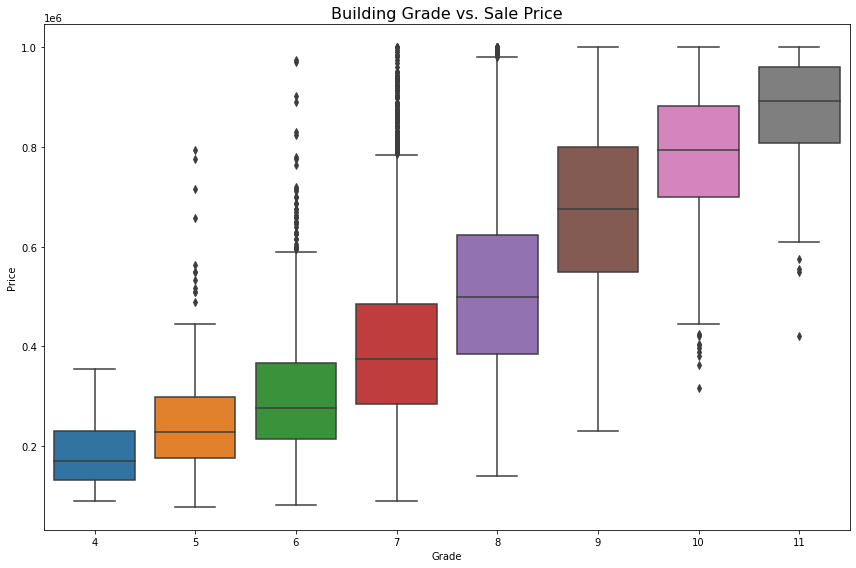

In [62]:
plt.figure(figsize=(12, 8))
sns.boxplot(df.grade, df.price)
plt.title('Building Grade vs. Sale Price', fontsize=16)
plt.xlabel('Grade')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

In [63]:
bedrooms_1_5 = df.loc[(df['distance'] <= 5) & (df['bedrooms'] < 2)]
bedrooms_2_5 = df.loc[(df['distance'] <= 5) & (df['bedrooms'] >= 2) & (df['bedrooms'] < 3)]
bedrooms_3_5 = df.loc[(df['distance'] <= 5) & (df['bedrooms'] >= 3) & (df['bedrooms'] < 4)]
bedrooms_4_5 = df.loc[(df['distance'] <= 5) & (df['bedrooms'] == 4)]

In [64]:
bedrooms_1 = df.loc[(df['distance'] > 5) & (df['bedrooms'] < 2)]
bedrooms_2 = df.loc[(df['distance'] > 5) & (df['bedrooms'] >= 2) & (df['bedrooms'] < 3)]
bedrooms_3 = df.loc[(df['distance'] > 5) & (df['bedrooms'] >= 3) & (df['bedrooms'] < 4)]
bedrooms_4 = df.loc[(df['distance'] > 5) & (df['bedrooms'] == 4)]

In [65]:
names = ['1 Bedroom Houses', '2 Bedroom Houses', '3 Bedroom Houses', '4 Bedroom Houses']
medians_5 = [bedrooms_1_5.price.median(), bedrooms_2_5.price.median(), bedrooms_3_5.price.median(), bedrooms_4_5.price.median()]
medians = [bedrooms_1.price.median(), bedrooms_2.price.median(), bedrooms_3.price.median(), bedrooms_4.price.median()]

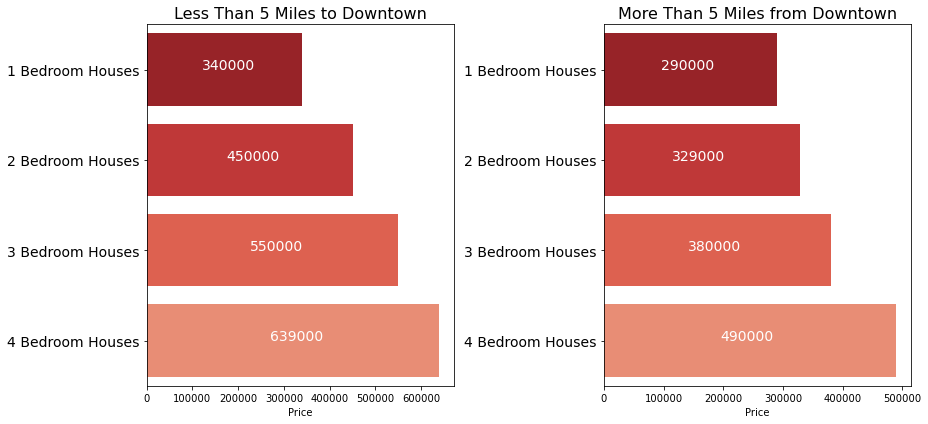

In [66]:
sns.set_palette('Reds_r')
plt.figure(figsize=(13, 6))
plt.subplot(1, 2, 1)
sns.barplot(medians_5, names)
for i in range(len(medians_5)):
    plt.text(x= (medians_5[i]/2) - 50000, y=i, s=int(medians_5[i]), c='white', fontsize=14)
plt.title('Less Than 5 Miles to Downtown', fontsize=16)
plt.xlabel('Price')
plt.yticks(fontsize=14)

plt.subplot(1, 2, 2)
for i in range(len(medians)):
    plt.text(x= (medians[i]/2) - 50000, y=i, s=int(medians[i]), c='white', fontsize=14)
sns.barplot(medians, names)
plt.title('More Than 5 Miles from Downtown', fontsize=16)
plt.xlabel('Price')
plt.yticks(fontsize=14)
plt.subplots_adjust(wspace=0.4)
plt.tight_layout()
plt.show()

In [67]:
sqft_under1250_5 = df.loc[(df['distance'] <= 5) & (df['sqft_living'] < 1250)]
sqft_under2500_5 = df.loc[(df['distance'] <= 5) & (df['sqft_living'] >= 1250) & (df['sqft_living'] < 2500)]
sqft_under3750_5 = df.loc[(df['distance'] <= 5) & (df['sqft_living'] >= 2500) & (df['sqft_living'] < 3750)]
sqft_under5000_5 = df.loc[(df['distance'] <= 5) & (df['sqft_living'] >= 3750) & (df['sqft_living'] <= 5000)] 

In [68]:
sqft_under1250 = df.loc[(df['distance'] > 5) & (df['sqft_living'] < 1250)]
sqft_under2500 = df.loc[(df['distance'] > 5) & (df['sqft_living'] >= 1250) & (df['sqft_living'] < 2500)]
sqft_under3750 = df.loc[(df['distance'] > 5) & (df['sqft_living'] >= 2500) & (df['sqft_living'] < 3750)]
sqft_under5000 = df.loc[(df['distance'] > 5) & (df['sqft_living'] >= 3750) & (df['sqft_living'] <= 5000)] 

In [69]:
names = ['Under 1250 Square Feet', 'Under 2500 Square Feet', 'Under 3250 Square Feet', 'Under 5000 Square Feet']
sqft_medians_5 = [sqft_under1250_5.price.median(), sqft_under2500_5.price.median(), sqft_under3750_5.price.median(), sqft_under5000_5.price.median()]
sqft_medians = [sqft_under1250.price.median(), sqft_under2500.price.median(), sqft_under3750.price.median(), sqft_under5000.price.median()]

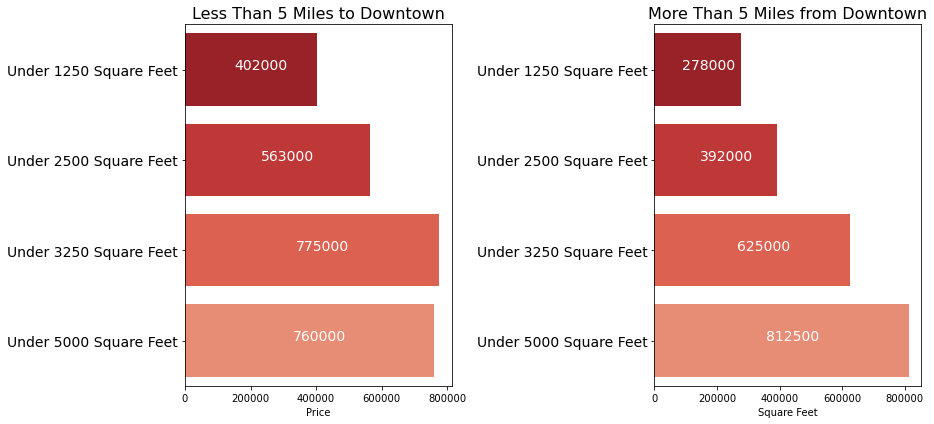

In [70]:
sns.set_palette('Reds_r')
plt.figure(figsize=(13, 6))
plt.subplot(1, 2, 1)
sns.barplot(sqft_medians_5, names)
for i in range(len(sqft_medians_5)):
    plt.text(x= (sqft_medians_5[i]/2) - 50000, y=i, s=int(sqft_medians_5[i]), c='white', fontsize=14)
plt.title('Less Than 5 Miles to Downtown', fontsize=16)
plt.xlabel('Price')
plt.yticks(fontsize=14)

plt.subplot(1, 2, 2)
for i in range(len(sqft_medians)):
    plt.text(x= (sqft_medians[i]/2) - 50000, y=i, s=int(sqft_medians[i]), c='white', fontsize=14)
sns.barplot(sqft_medians, names)
plt.title('More Than 5 Miles from Downtown', fontsize=16)
plt.xlabel('Square Feet')
plt.yticks(fontsize=14)
plt.subplots_adjust(wspace=0.4)
plt.tight_layout()
plt.show()

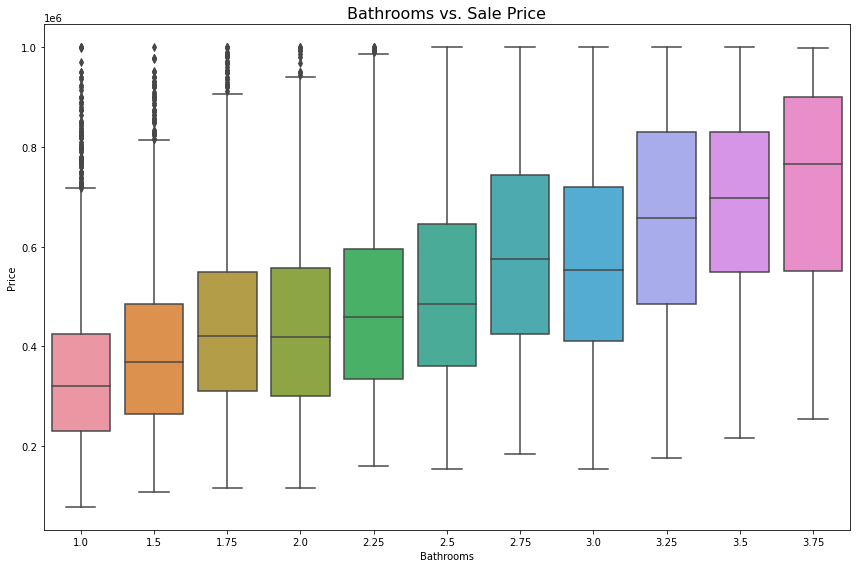

In [71]:
plt.figure(figsize=(12, 8))
sns.boxplot(df.bathrooms, df.price)
plt.title('Bathrooms vs. Sale Price', fontsize=16)
plt.xlabel('Bathrooms')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

### Final Conclusions

* Location is everything. Houses that are located closer to downtown are generally more expensive than houses that are located outside of downtown.

* If you're on a budget and looking to buy a small house, a house outside of the city should be cheaper than one inside the city.

* Larger family homes also might be cheaper outside of the city. However, it appears that some of the data on the cost of larger houses might be affected by some houses that are listed as waterfront property.

* Generally speaking, the age of a home also affects its price. According to the King County Assessor's grading system, older homes tend to have lower grades compared to newer ones. Building grade also affects price, as the higher the building grade, the higher the price.

* Bathrooms also tend to affect the cost of a house. Houses with more bathrooms tend to be priced higher than houses with fewer bathrooms.

## Recommendations

* Linear regression doesn't appear to be the best method of predicting housing prices with great accuracy. An error of over $100,000 in price and some outliers in the residuals seems to show that. Other types of models should be considered in order to see if a different type of model might be more accurate.